In [30]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import pickle
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
import corner
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
import CL_WL_miscentering as mis
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_DATAOPS_match_catalogs as match
import CL_WL_DATAOPS_make_profile as prf
import CL_Likelihood_for_Mass_richness_relation as mass_richness
import CL_WL_fit_cluster_mass as fit
import CL_fiducial_mass_richness_relation as fiducial
import analysis_Mass_observable_relation as analysis


import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
import astropy.units as un
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl

cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [32]:
profile_SkySim = load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/individual_profile_SkySim5000_gal_redMaPPer_cluster_epsilon_shape_true_z.pkl')

In [5]:
sum_weights_per_cluster_10 = []
sum_weights_per_cluster_5 = []
for i, cl in enumerate(profile_SkySim):
    mask = (profile_SkySim['radius_av'][i] > 1)*(profile_SkySim['radius_av'][i] < 10)
    sum_weights_per_cluster_10.append(np.sum(profile_SkySim['norm_sum'][i][mask]))
    mask = (profile_SkySim['radius_av'][i] > 1)*(profile_SkySim['radius_av'][i] < 5.5)
    sum_weights_per_cluster_5.append(np.sum(profile_SkySim['norm_sum'][i][mask]))

In [6]:
profile_SkySim['weight_per_cluster_5'] = np.array(sum_weights_per_cluster_5)*1e27
profile_SkySim['weight_per_cluster_10'] = np.array(sum_weights_per_cluster_10)*1e27

In [7]:
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin
Gamma_5 = 0.75
Gamma_10 = 0.8

# Fiducial Mass richness relation

In [33]:
fiducial_constraint = fiducial.constrain_fiducial(used_cluster_id_list = np.array(profile_SkySim['cluster_id']), low_M_cut = 3e13)

100%|██████████| 100/100 [00:13<00:00,  7.61it/s]


In [9]:
fiducial_constraint

array([14.15930587, -0.21986331,  0.73194591])

In [10]:
#err = (binned_data['m200_err'])/(np.log(10)*np.array(binned_data['m200']))
#err_logl = (binned_data['richness_err'])/(np.log(10)*10**np.array(binned_data['logrichness']))
#plt.rcParams['axes.linewidth'] = 3
#i_fits = [0,0,1,1]
#j_fits = [1,0,1,0]
#plt.figure(figsize = (10,7))
#color_z = ['orange','red','magenta','purple','green','cyan','blue','black']
#x = np.linspace(1,3,100)
#y = 0.7*x + 13.2
#for k, z_bin in enumerate(Z_bin):
#        plt.plot([],[], '-', c = color_z[k],label = f'{z_bin[0]:.2f}'+ r'$< z < $'+ f'{z_bin[1]:.2f}',)
#        mask = (binned_data['z_mean'] > z_bin[0])*(binned_data['z_mean'] < z_bin[1])
#        f_cut = Table(binned_data)[mask]
#        a_t = 1./(1 + f_cut['z_mean'])
##        logrichness = f_cut['logrichness']
#        logrichness_err = err_logl[mask]
#        logm200w = np.log10(f_cut['m200'])
#        logm200w_err = err[mask]
#        plt.errorbar(logrichness,logm200w,logm200w_err, logrichness_err,
#                marker = '.', 
#                elinewidth = 2, capsize = 0, markersize = 7, c = color_z[k],
#                    markerfacecolor = None)
##plt.xlim(1.3,2.4)
#plt.ylim(14,14.8)
#plt.legend(fontsize = 20)
#plt.tick_params(axis='both', which = 'major', labelsize= 20)
##plt.grid('True')
#plt.xlabel(r'$\log_{10}(\langle \lambda \rangle)$', fontsize = 30)
#plt.ylabel(r'$\log_{10}(\langle M_{\rm 200c}^{\rm}\rangle)$', fontsize = 30)
#plt.show()
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/est_mass_validation.png', bbox_inches='tight', dpi=300)

# WL masses

In [11]:
profile_SkySim_cut = profile_SkySim

## WL shear profiles

In [12]:
profile_sky_stack = prf.stacked_profile(profile = profile_SkySim_cut,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin,
                    add_columns_to_bin = ['weight_per_cluster_10','weight_per_cluster_5', 'richness'])

covariance_sky_stack = prf.bootstrap_covariance(profile = profile_SkySim_cut,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    n_boot = 400,
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


## Fit WL masses

In [13]:
%load_ext autoreload
%autoreload 2
import CL_WL_fit_cluster_mass as fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
fix_c_Diemer15 =       fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = True, mc_relation = 'Diemer15')
fix_c_Duffy08 =        fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = True, mc_relation = 'Duffy08')
fix_c_Prada12 =        fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = True, mc_relation = 'Prada12')
fix_c_Bhattacharya13 = fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = True, mc_relation = 'Bhattacharya13')
free_c_1h =            fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = False)

In [15]:
#fix_c_2h = fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = 0, b = 1, rmax = 10, two_halo_term = True, fix_c = True)
##fix_c_1h = fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = True)
#free_c_2h = fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = 0, b = 1, rmax = 10, two_halo_term = True, fix_c = False)
#free_c_1h = fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = False)

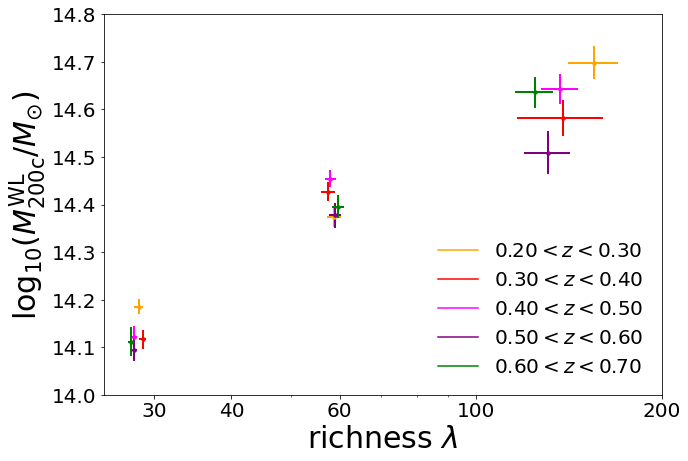

In [16]:
import matplotlib.ticker
fig, ax  = plt.subplots(figsize = (10,7))
color_z = ['orange','red','magenta','purple','green','cyan','blue','black']
x = np.linspace(1,3,100)
f = free_c_1h
for k, z_bin in enumerate(Z_bin):
        f = Table(f)
        plt.plot([],[], '-', c = color_z[k],label = f'{z_bin[0]:.2f}'+ r'$< z < $'+ f'{z_bin[1]:.2f}',)
        mask = (f['z_mean'] > z_bin[0])*(f['z_mean'] < z_bin[1])
        f_cut = f[mask]
        a_t = 1./(1 + f_cut['z_mean'])
        richness = f_cut['obs_mean']
        richness_err = f_cut['obs_rms']
        logm200w = f_cut['logm200_w']
        logm200w_err = f_cut['logm200_w_err']
        ax.errorbar(richness,logm200w,logm200w_err, richness_err,
                    marker = '.', fmt = ' ',
                    elinewidth = 2, capsize = 0, markersize = 7, c = color_z[k],
                        markerfacecolor = None)

ax.set_ylim(14,14.8)
ax.set_xscale('log')
ax.tick_params(axis='both', which = 'major', labelsize= 20)
ax.set_xticks([30,40, 60, 100, 200])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(frameon = False, fontsize = 20, loc = 'lower right')
ax.set_xlabel(r'richness $\lambda$', fontsize = 30)
ax.set_ylabel(r'$\log_{10}(M_{\rm 200c}^{\rm WL}/M_{\odot})$', fontsize = 30)
plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/est_mass_validation_free_c_1h.png', bbox_inches='tight', dpi=300)
#plt.show()

In [17]:
#fits = [fix_c_2h,fix_c_1h,free_c_2h,free_c_1h]
#text = ['c-M, 2h', 'c-M, 1h','free c, 2h','free c, 1h']

In [18]:
#plt.rcParams['axes.linewidth'] = 3
#fig, axs = plt.subplots(2, 2, figsize = (10,10), sharex=True, sharey=True)
#plt.rcParams['axes.linewidth'] = 3
#fig.subplots_adjust(wspace=0, hspace=0)
#i_fits = [0,0,1,1]
#j_fits = [1,0,1,0]
#color_z = ['orange','red','magenta','purple','green','cyan','blue','black']
#x = np.linspace(1,3,100)
#y = 0.7*x + 13.2
#for i,f in enumerate(fits):
#    f = Table(f)
#    for k, z_bin in enumerate(Z_bin):
#            if i == 0:      
#                axs[i_fits[i],j_fits[i]].plot([],[], '-', c = color_z[k],label = f'{z_bin[0]:.2f}'+ r'$< z < $'+ f'{z_bin[1]:.2f}',)
#            mask = (f['z_mean'] > z_bin[0])*(f['z_mean'] < z_bin[1])
#            f_cut = f[mask]
#            a_t = 1./(1 + f_cut['z_mean'])
#            richness = f_cut['obs_mean']
#            richness_err = f_cut['obs_rms']
#            logm200w = f_cut['logm200_w']
#            logm200w_err = f_cut['logm200_w_err']
#            axs[i_fits[i],j_fits[i]].text(1.5, 14.7, text[i], fontsize = 20)
#            axs[i_fits[i],j_fits[i]].errorbar(np.log10(richness),logm200w,logm200w_err, richness_err/(np.log(10)*richness),
#                    marker = '.', 
#                    elinewidth = 2, capsize = 0, markersize = 7, c = color_z[k],
#                        markerfacecolor = None)
#    axs[i_fits[i],j_fits[i]].set_xlim(1.3,2.4)
#    axs[i_fits[i],j_fits[i]].set_ylim(14,14.8)
#    axs[i_fits[i],j_fits[i]].plot(x,y,'--k')
#    axs[i_fits[i],j_fits[i]].tick_params(axis='both', which = 'major', labelsize= 20)
#    axs[i_fits[i],j_fits[i]].legend(frameon = False, fontsize = 20, loc = 'lower right')
#    axs[i_fits[i],j_fits[i]].grid('True')
#    axs[i_fits[i],j_fits[i]].set_xlabel(r'$\log_{10}(\langle \lambda \rangle)$', fontsize = 15)
#    if j_fits[i] == 0:
#        axs[i_fits[i],j_fits[i]].set_ylabel(r'$\log_{10}(\langle M_{\rm 200c}^{\rm WL}\rangle)$', fontsize = 15)
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/est_wl_mass.png', bbox_inches='tight', dpi=300)

In [19]:
#fig, axs = plt.subplots(2, 2, figsize = (10,10), sharex=True, sharey=True)
#plt.rcParams['axes.linewidth'] = 1
#fig.subplots_adjust(wspace=0, hspace=0)
#i_fits = [0,0,1,1]
#j_fits = [1,0,1,0]
#color_z = ['orange','red','magenta','purple','green','cyan','blue','black']
#x = np.linspace(1,3,100)
#y = 0.7*x + 13.2
#for i,f in enumerate(fits):
#    f = Table(f)
#    for k, z_bin in enumerate(Z_bin):
##            if i == 0:
#                axs[i_fits[i],j_fits[i]].plot([],[], '-', c = color_z[k],label = f'{z_bin[0]:.2f}'+ r'$< z < $'+ f'{z_bin[1]:.2f}',)
#            mask = (f['z_mean'] > z_bin[0])*(f['z_mean'] < z_bin[1])
#            f_cut = f[mask]
#@            f_cut_validation = Table(binned_data)[mask]
#            a_t = 1./(1 + f_cut['z_mean'])
#            logm200 = np.log10(f_cut_validation['m200'])
#            logm200w = f_cut['logm200_w']
#            logm200w_err = f_cut['logm200_w_err']
#            axs[i_fits[i],j_fits[i]].text(14.1, 14.6, text[i], fontsize = 30)
#            axs[i_fits[i],j_fits[i]].errorbar(logm200,logm200w,logm200w_err,
#                    marker = '.', 
#                    elinewidth = 2, capsize = 0, markersize = 7, c = color_z[k],
#                        markerfacecolor = None)
 #   axs[i_fits[i],j_fits[i]].set_xlim(14,14.8)
#    axs[i_fits[i],j_fits[i]].set_ylim(14,14.8)
#    axs[i_fits[i],j_fits[i]].plot(y,y,'--k')
#    axs[i_fits[i],j_fits[i]].tick_params(axis='both', which = 'major', labelsize= 20)
#    axs[i_fits[i],j_fits[i]].legend(frameon = False, fontsize = 10, loc = 'lower right')
#    axs[i_fits[i],j_fits[i]].grid('True')
#    axs[i_fits[i],j_fits[i]].set_xlabel(r'$\log_{10}(\langle M_{\rm 200c}\rangle)$', fontsize = 30)
#    if j_fits[i] == 0:
#        axs[i_fits[i],j_fits[i]].set_ylabel(r'$\log_{10}(\langle M_{\rm 200c}^{\rm WL}\rangle)$', fontsize = 30)
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/est_wl_mass_mass.png', bbox_inches='tight', dpi=300)

# WL Mass-richness relation

In [20]:
fits = [fix_c_Duffy08, fix_c_Prada12, fix_c_Bhattacharya13, fix_c_Diemer15, free_c_1h]
label_fits = ['Duffy08', 'Prada12', 'Bhattacharya13', 'Diemer15',  'free']

In [21]:
from scipy.stats import norm
def lnL_WL_binned_Gamma(theta, m200c_mean, m200c_err_mean, richness_individual, z_individual, weight_individual, Gamma):
    return mass_richness.lnL_WL_binned_Gamma(theta, m200c_mean, m200c_err_mean, richness_individual, z_individual, weight_individual, Gamma, analysis.z0, analysis.richness0)

In [22]:

Gamma_5 = 0.79
Gamma_10 = 0.75
Gamma = [Gamma_5, Gamma_5, Gamma_5, Gamma_5, Gamma_5]

npath = 100
ndim = 3
nwalkers = 100
initial_binned = [14.15,0,0.75]
pos_binned = initial_binned + 0.01 * np.random.randn(npath, len(initial_binned))

_5_or_10 = ['5', '5', '5', '5', '5']
sampler = {name : 0 for name in label_fits}
for i,fit_true in enumerate(fits):
    
    m200c_mean = 10**np.array(fit_true['logm200_w'])
    m200c_err_mean =np.array(fit_true['logm200_w_err'])*np.log(10)*m200c_mean
    richness_individual = np.array(fit_true['obs_individual'])
    richness_mean = np.array([np.mean(richness_individual[i]) for i in range(len(richness_individual))])
    z_individual = fit_true['z_individual']
    z_mean = np.array([np.mean(z_individual[i]) for i in range(len(z_individual))])
    weight_individual = fit_true['weight_per_cluster' + '_' + _5_or_10[i]]
    sampler_binned = emcee.EnsembleSampler(nwalkers, ndim, lnL_WL_binned_Gamma, args = (m200c_mean, m200c_err_mean, richness_individual, z_individual, weight_individual, Gamma[i]))
    sampler_binned.run_mcmc(pos_binned, npath, progress=True);
    sampler_binned_wl = sampler_binned.get_chain(discard = 0, flat = True)
    sampler[label_fits[i]] = sampler_binned_wl

100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


In [23]:
##label_plot = [r'WL no c(M) - 1h' ,r'WL free concentration, 1h + 2h',r'WL c(M) - 1h' ,r'WL fix concentration, 1h + 2h','fiducial',]
##sampler_tot = [ sampler['free_c_1h'],sampler['free_c_2h'], sampler['fix_c_1h'],sampler['fix_c_2h'],flat_samples_binned_true]

In [24]:
label_plot = label_fits
sampler_tot = [sampler[keys] for keys in sampler.keys()]

In [25]:
k = sampler['free']
a = len(k)
middle = np.mean(k[5000:a-1], axis = 0)
std = np.std(k[5000:a-1], axis = 0)
range_corner_plot = [(middle[i]- 3.1*std[i], middle[i]+ 3.1*std[i]) for i in range(3)]

In [26]:
range_corner_plot

[(14.13320752941044, 14.191812944046491),
 (-0.6632354408452078, 0.2573552344584996),
 (0.6640489388710319, 0.826573487028548)]

10000
10000
10000


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


10000
10000


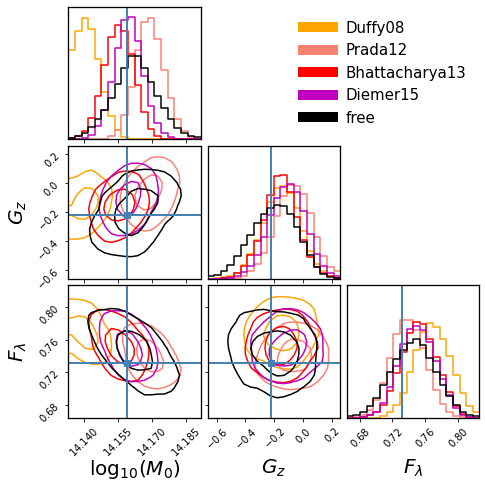

In [29]:
plt.rcParams['axes.linewidth'] = 1.3
labels_param = [r'$\log_{10}(M_{0})$', r'$G_z$',r'$F_\lambda$']
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)
truth = [14.162, -0.23, 0.8]
bins = 20
c = ['orange', 'salmon', 'r', 'm','k']
show = [True, True, True, True, True]
fill_contours = [False, False, False, False,  False]
fig, axs = plt.subplots(3,3, figsize = (7,7))
for i, name in enumerate(label_plot):
    if not show[i]: continue
    axs[0,2].plot([],[], c[i], linewidth = 10, label = label_fits[i])

for i,sample in enumerate(sampler_tot):
    if not show[i]: continue
    a = len(sample)
    print(a)
    sample_cut = sample[5000:a-1]
    fig = corner.corner(
    sample_cut,
    bins=bins, levels=(sigma1, sigma2),
        truths = fiducial_constraint,
    
    range = range_corner_plot,
    fig = fig,
    color = c[i],
        ls = '--',
    smooth1d=True,smooth=True,plot_datapoints=False,
    fill_contours=fill_contours[i], labels = labels_param,            
    label_kwargs={"fontsize": 20},
    use_math_text=True,
    show_title = True,
    plot_density=False,
    max_n_ticks = 5);
    
for i in range(3):
    for j in range(3):
        axs[i,j].tick_params(axis='both', which = 'major', labelsize= 10)
        axs[i,j].legend(frameon = False, fontsize = 15, loc = 'upper right')
        if i == j:
            axs[i,j].set_ylim(0,1000)

#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/MCMC_mass_Richness.png', bbox_inches='tight', dpi=300)